# TDA@HSE 2023

## Homework 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Task 1: Dynamical system classification

#### Problem
Persistence diagram is a multiset of vectors $D = \{(b_i, d_i, h_i)\}_{i=1}^N$ where $b_i$, $d_i$ are the birth and death times of $i$-th topological feature of dimension $h_i$. The classic approach to introduce persistent diagrams to machine learning is related to distances and kernels defined on the space of diagrams, which takes $O(n^2)$ time to compute. Vectrorization schemes such as persistence [images](https://arxiv.org/abs/1507.06217), [landscapes](https://arxiv.org/abs/1501.00179) or [curves](https://arxiv.org/abs/1904.07768) reduce the time to $O(n)$, yet all of this approaches are more or less fixed.

Trainable vectorization allows to learn vector representations of persistence diagrams, optimal w.r.t. the downstream task such as classification or regression. The simplest of such models, [Deep Sets](https://arxiv.org/abs/1703.06114) - $f: (\mathbb{R}^3)^N \rightarrow \mathbb{R}^d$

\begin{equation}
f(\{x_1, \dots, x_N\}) = \rho \left( \sum_{i=1}^N \phi(x_i) \right),
\end{equation}

consists of an encoder $\phi_\theta: \mathbb{R}^3 \rightarrow \mathbb{R}^D$ mapping each diagram point $x_i = (b_i, d_i, h_i)$, with parameters $\theta$ shared between points, a permutation invariant pooling operation $(\cdot): (\mathbb{R}^D)^N \rightarrow \mathbb{R}^D$ to obtain a representation of a diagram at whole (particulary for Deep Sets - sum pooling), and a decoder $\rho: \mathbb{R}^D \rightarrow \mathbb{R}^d$ which further transforms the diagram representation. It was [shown](https://arxiv.org/abs/1904.09378) that certain combinations of encoder/pooling/decoder correspond to the fixed representation schemes of persistence diagrams.

Deep sets encoder vectorizes each single point independently and does not consider the interdependence between points in the diagram. Thus, the self-attention block from the Transformer model which allows to capture those dependencies is a natural plug-in replacement to the encoder $\phi$.

\begin{equation}
\Phi_{ATTN}(\{x_1, \dots, x_N\}) = \left(\frac{(\mathbf{W}_q \mathbf{X})(\mathbf{W}_k \mathbf{X})^T}{\sqrt{D}} \right)\mathbf{W}_v\mathbf{X},
\end{equation}

where $\Phi_{ATTN}: (\mathbb{R}^3)^N \rightarrow (\mathbb{R}^D)^N$.

Yet, Transformers are known to be unstable to train, for example requiring the warm-up period. A recent line of work tries to address this issues, either experimenting with placing Layer Normalization block [[link](https://arxiv.org/abs/2002.04745), [link](https://arxiv.org/abs/1910.05895)], or removing it completely [[link]](https://arxiv.org/abs/2003.04887), effectively removing the warm-up period. There is also other architecture choices such as the type of self-attention, different from classic dot-product [[link](https://arxiv.org/abs/2006.04710),[link](https://arxiv.org/abs/2110.11773),[link](https://arxiv.org/abs/2005.09561)], try learnable pooling instead of fixed ones [[link]](https://arxiv.org/abs/1810.00825).

#### Task

Train the transformer model with various architecture choices on the _ORBIT5K_ TDA benchmark dataset, with 70/30 train/test split (_ORBIT100K_, if you are not limited in computational power). Report the average and standard deviation of the best achived performance over 10 runs. Conclude which architecture choices: _a)_ bring most performance gain, _b)_ allows for faster and more stable training.

Things to experiment with:
- layer normalization placement/ReZero,
- self-attention variants (L2, double-stochastic, non-normalized),
- learnable pooling vs fixed such as max/mean/sum,
- cross-attention.

Baseline accuracies (_ORBIT5K_):
- Persistence images: $84.8$ 
- Perslay: $87.7$
- Persformer: $90.4$

#### Points

Points for this task will be assigned depending on the ranking in the overall results leaderboard.

#### References

Models:

- Deep Sets [[link]](https://arxiv.org/abs/1703.06114)
- Perslay [[link]](https://arxiv.org/abs/1904.09378)
- Persformer [[link]](https://arxiv.org/abs/2112.15210)
- Set Transformer [[link]](https://arxiv.org/abs/1810.00825)

General tips:

- Training Tips for the Transformer Model [[link]](https://arxiv.org/abs/1804.00247)
- Understanding the Difficulty of Training Transformers [[link]](https://arxiv.org/abs/2004.08249)
- Universal Approximation of Functions on Sets [[link]](https://arxiv.org/abs/2107.01959)

Alternatives to the dot-product self-attention:
- The Lipschitz Constant of Self-Attention (L2 attention) [[link]](https://arxiv.org/abs/2006.04710)
- Sinkformers: Transformers with Doubly Stochastic Attention (doubly stochatic attention) [[link]](https://arxiv.org/abs/2110.11773)
- Normalized Attention Without Probability Cage (non-normalized attention) [[link]](https://arxiv.org/abs/2005.09561)

Layer normalization (where to put LN? pre or post?):

- On Layer Normalization in the Transformer Architecture [[link]](https://arxiv.org/abs/2002.04745)
- Transformers without Tears: Improving the Normalization of Self-Attention [[link]](https://arxiv.org/abs/1910.05895)

Alternatives to layer normalization:
- ReZero is All You Need: Fast Convergence at Large Depth (no normalization at all, no warmup) [[link]](https://arxiv.org/abs/2003.04887)
- NormFormer: Improved Transformer Pretraining with Extra Normalization [[link]](https://arxiv.org/abs/2110.09456)

Alternative permutation-invariant pooling:

- Set Transformer (learn pooling operation instead of max/mean/sum) [[link]](https://arxiv.org/abs/1810.00825)

Cross-attention (attending to learned vector, fixed attention matrix size):
- Perceiver: General Perception with Iterative Attention [[link]](https://arxiv.org/abs/2103.03206)
- Visual Parser: Representing Part-whole Hierarchies with Transformers [[link]](https://arxiv.org/abs/2107.05790)

In [2]:
def generate_orbit(point_0, r, n=1000):

    X = np.zeros([n, 2])

    xcur, ycur = point_0[0], point_0[1]

    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]

    return X

In [3]:
def generate_orbits(m, rs=[2.5, 3.5, 4.0, 4.1, 4.3], n=1000, random_state=0):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j])
            
    return orbits

#### ORBIT5K dataset

Persistence Images: A Stable Vector Representation of Persistent Homology. _Adams et al._ (2017) [[link]](https://arxiv.org/abs/1507.06217)

You can compute diagrams for _ORBIT5K_ with

- Ripser `pip install ripser` [[link]](https://ripser.scikit-tda.org),
- parallel Ripser `pip install giotto-ph` [[link]](https://giotto-ai.github.io/giotto-ph/build/html/modules/ripser_parallel.html),
- Ripser++ (GPU-accelerated) `pip install ripserplusplus` [[link]](https://github.com/simonzhang00/ripser-plusplus).

In [4]:
random_state = np.random.RandomState(0)
X_orbit5k = generate_orbits(1000, random_state=random_state)

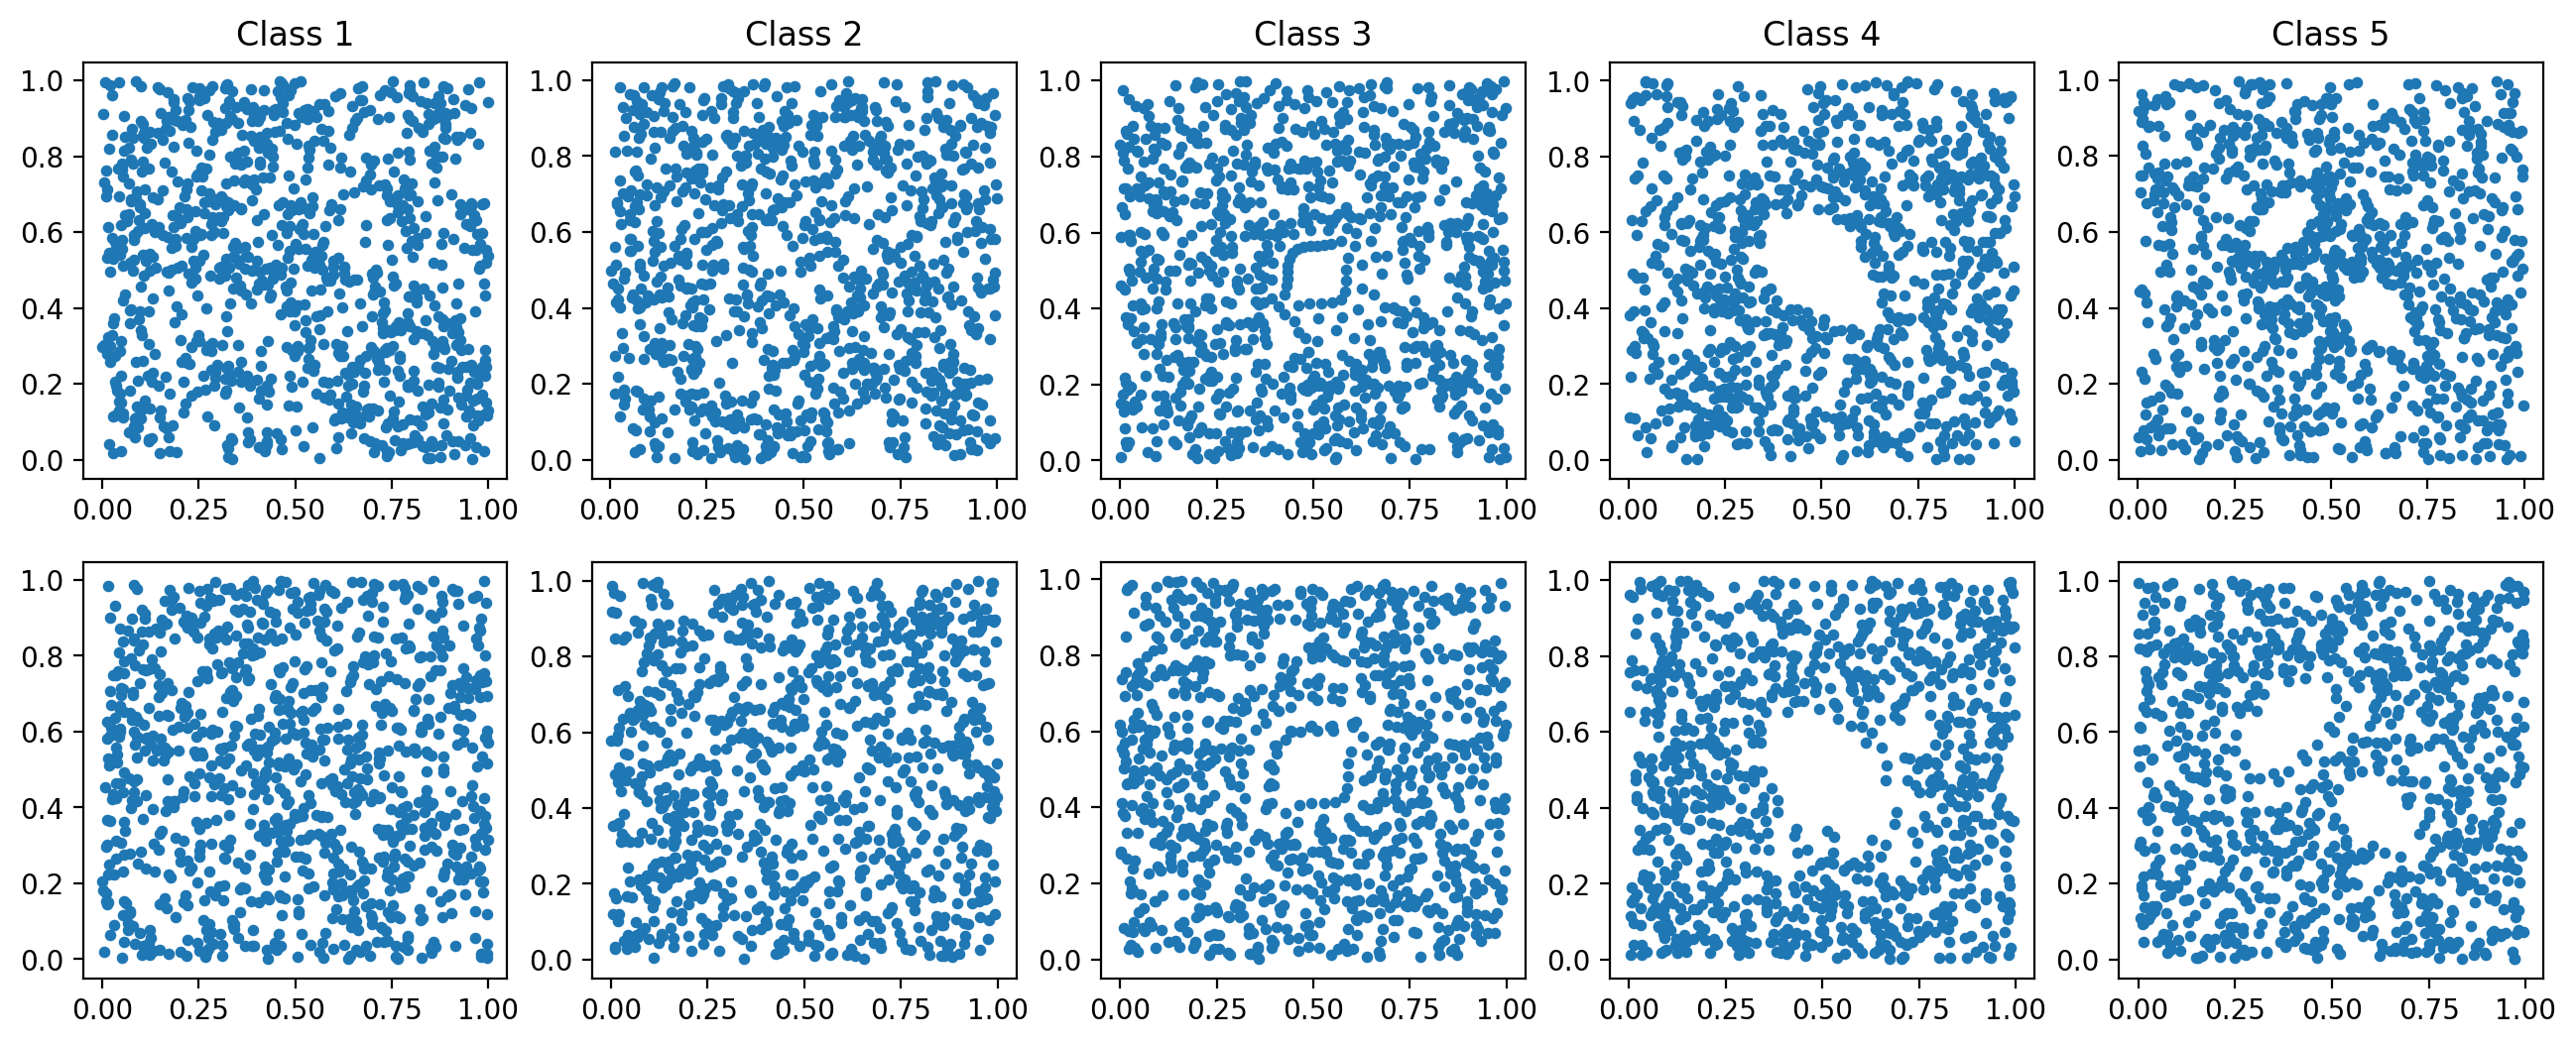

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6), dpi=200)
for i in range(2):
    for j in range(5):
        if i==0:
            ax[i,j].set_title("Class {}".format(j+1))
        ax[i,j].scatter(X_orbit5k[j*1000+i,:,0], X_orbit5k[j*1000+i,:,1], s=10)

In [6]:
!pip install gudhi
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'perslay' already exists and is not an empty directory.
rm: cannot remove '/content/perslay/tutorial/data': No such file or directory


In [ ]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import sys
import numpy as np
import tensorflow as tf
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui

sys.path.append('./perslay/')

!cd ./perslay/

from perslay.perslay import PerslayModel

# from tutorial.experiments import *
from tutorial.experiments import (
    evaluate_model, generate_diagrams_and_features, get_model, load_data
)

In [8]:
# dataset = "ORBIT5K"
if not os.path.isdir('./data'):
  os.mkdir('./data')
generate_diagrams_and_features(X_orbit5k, path_dataset="./data")
diags_dict, F, L = load_data(path_dataset="./data")
F = np.array(F, dtype=np.float64)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
model, optimizer, loss, metrics = get_model(F.shape[1])

In [10]:
import gudhi.representations as tda

### Uncomment the following to process your diagrams (necessary)
thresh = 500

# Whole pipeline
tmp = Pipeline([
        ("Selector", tda.DiagramSelector(use=True, point_type="finite")),
        ("ProminentPts", tda.ProminentPoints(use=True, num_pts=thresh)),
        ("Scaler", tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
        ("Padding", tda.Padding(use=True)),
])

prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
       for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

# Apply the previous pipeline on the different filtrations.
diags = []
for dt in prm.keys():
    param = prm[dt]
    tmp.set_params(**param)
    diags.append(tmp.fit_transform(diags_dict[dt]))

# For each filtration, concatenate all diagrams in a single array.
D, npts = [], len(diags[0])
for dt in range(len(prm.keys())):
    D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))

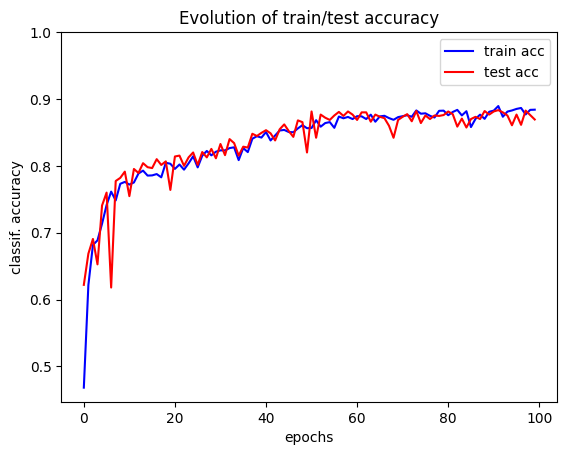

Train accuracy = 0.8828571438789368, test accuracy = 0.8693333268165588


In [11]:
num_pts = len(D[0])

test_size = 0.3
epochs = 100

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

In [12]:
# vectors = model.compute_representations(D).numpy()
# train_vect, test_vect = np.hstack([vectors[train], F[train]]), np.hstack([vectors[test], F[test]])
# train_labs, test_labs = np.argmax(L[train], axis=1), np.argmax(L[test], axis=1)

# clf = Pipeline([("Estimator", SVC())])
# clf_prms = [{"Estimator": [RandomForestClassifier()]},
#             {"Estimator": [SVC()],
#              "Estimator__kernel": ["linear", "rbf"], 
#              "Estimator__C": [0.1, 1, 10]},
#             {"Estimator": [AdaBoostClassifier()]}]
# classifier = GridSearchCV(clf, clf_prms, cv=5)

# classifier.fit(train_vect, train_labs)
# tr = classifier.score(train_vect, train_labs)
# te = classifier.score(test_vect,  test_labs)

# print("Train accuracy = " + str(tr) + ", test accuracy = " + str(te))

In [13]:
# num_folds = 10
# epochs = 100

# folds = KFold(n_splits=num_folds, random_state=42, shuffle=True).split(np.empty([num_pts]))

# test_size = 0.3
# folds = ShuffleSplit(n_splits=num_folds, test_size=test_size, random_state=42).split(np.empty([num_pts]))

# tr, te = [], []
# for (ir, ie) in folds:
#     model, optimizer, loss, metrics = get_model(F.shape[1])
#     _, sr, se = evaluate_model(L, F, D, ir, ie, model, optimizer, loss, metrics, num_epochs=epochs, verbose=0)
#     tr.append(sr[1])
#     te.append(se[1])

# print("Train accuracy = " + str(np.mean(tr)) + ", test accuracy = " + str(np.mean(te)))

In [14]:
model, optimizer, loss, metrics = get_model(F.shape[1],
                                            {"lpeq": [(25, None), (25, "max"), (25, "sum")]})

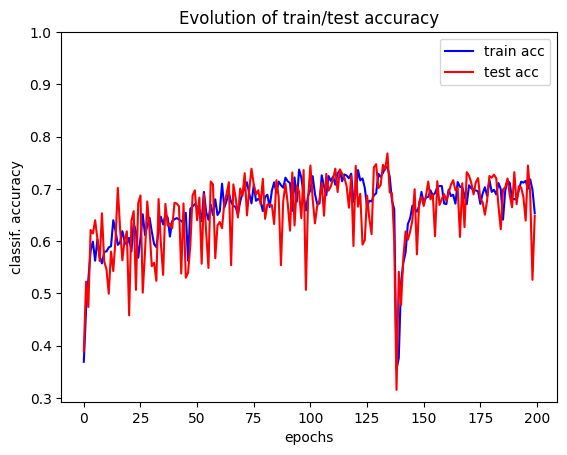

Train accuracy = 0.6468571424484253, test accuracy = 0.6486666798591614


In [15]:
num_pts = len(D[0])

test_size = 0.3
epochs = 200

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

In [25]:
model, optimizer, loss, metrics = get_model(F.shape[1], {"pweight": "power",
                                                         "pweight_power": 0.99})

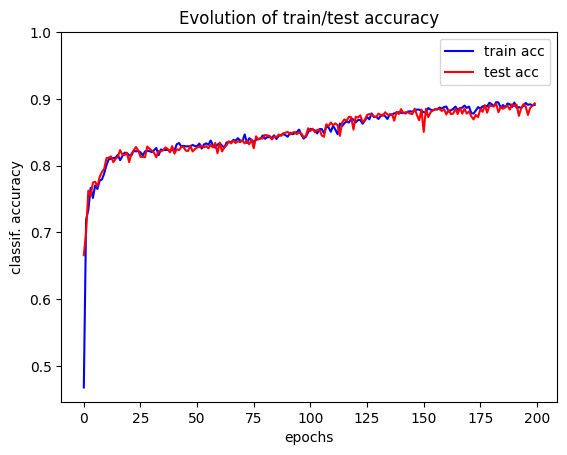

Train accuracy = 0.8982856869697571, test accuracy = 0.8933333158493042


In [26]:
num_pts = len(D[0])

test_size = 0.3
epochs = 200

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

После череды экспериментов замечаем, что `accuracy` не особо растет после 50й эпохи. Более того, точность довольно сильно колеблется. Это наводит нас на мысль поменять `lr_scheduler`

In [27]:
model, _, loss, metrics = get_model(F.shape[1], {"pweight": "power", "pweight_power": 0.99})

lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.012, decay_steps=150, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)

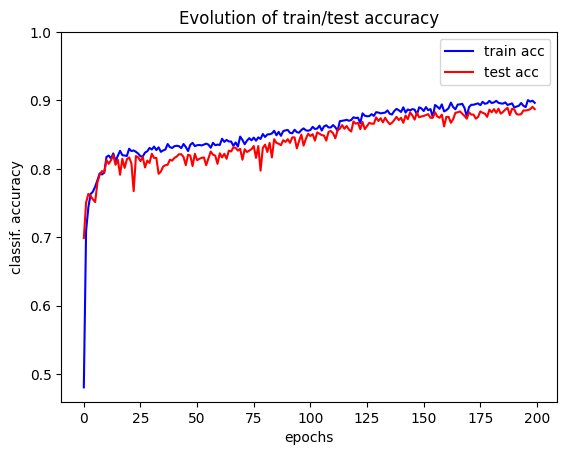

Train accuracy = 0.9037142992019653, test accuracy = 0.887333333492279


In [28]:
num_pts = len(D[0])

test_size = 0.3
epochs = 200

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

Изменение `optimizer` привело к лучшему качеству, зато, судя по графику, `accuracy` модели имеет тенденции к росту. Попробуем поучить подольше

In [29]:
model, _, loss, metrics = get_model(F.shape[1], {"pweight": "power", "pweight_power": 0.99})

lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.012, decay_steps=150, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)

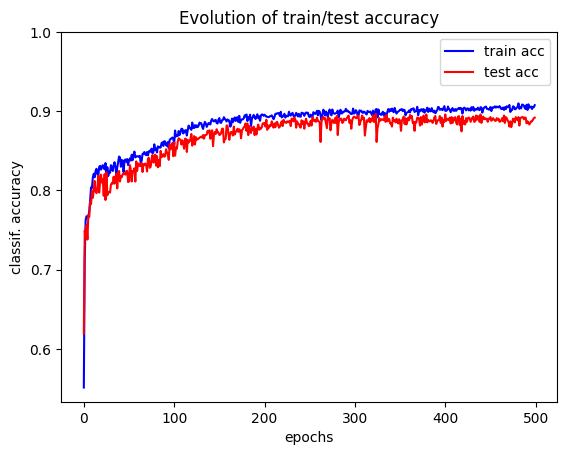

Train accuracy = 0.9085714221000671, test accuracy = 0.8920000195503235


In [30]:
num_pts = len(D[0])

test_size = 0.3
epochs = 500

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

In [31]:
model, optimizer, loss, metrics = get_model(F.shape[1], {"lpeq": [(25, "max")]})

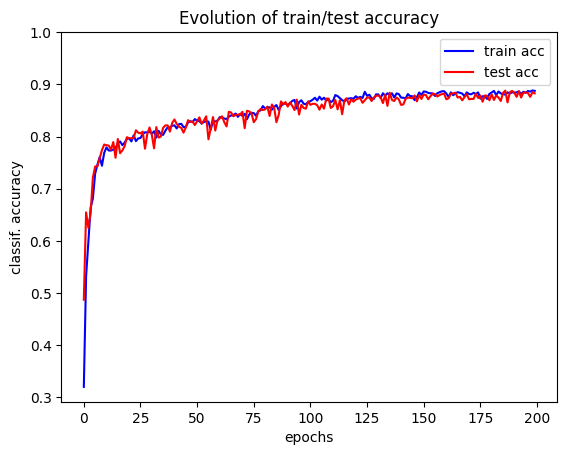

Train accuracy = 0.8914285898208618, test accuracy = 0.8826666474342346


In [32]:
num_pts = len(D[0])

test_size = 0.3
epochs = 200

random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

_, tr, te = evaluate_model(L,F,D,train,test,model,optimizer,loss,metrics,num_epochs=epochs,verbose=0,plots=True)

print("Train accuracy = " + str(tr[1]) + ", test accuracy = " + str(te[1]))

По итогу эксперименты улучшили качество, по сравнению с бейзлайном, причем почти каждый эксперимент показывал качество лучше. Тем не менее, различие незначительно. Но проведенные эксперименты охватывают далеко не все возможные способы улучшить модель. Приведем здесь некоторые возможные:
- `lr_scheduler`. Как указывалось выше, его выбор может значительно стабилизировать обучение, по итогу улучшив качество
- выбор `rho` в модели. Сейчас в качестве `rho` выбран простенький линейный слой. Качество можно пытаться улучшить, переропределив `rho` какой-нибудь нейросетью. Как раз здесь можно пытаться применить `transformer-based` архитектуры. Хотя начать можно и с `feed-forward`
- можно пытаться аугментировать данные также для большей стабильности при увеличении числа эпох обучения.
- навешивать `estimators` на обученную модель (пример выше). Они за относительно небольшое время позволяют улучшить качество итогового классификатора.

### Task 2: Graph classification

TBA

In [ ]:
# your code here